# Looking at the populations of employees as time series
## May 14,2015
### Most importantly load the dataset and transform it into a time series, noting how many are hired, separated and active each month

In [65]:
import pandas as pd
import os
import matplotlib.pylab as plt
import seaborn as sns
%matplotlib inline
import numpy as np

In [66]:
print plt.style.available
plt.style.use('fivethirtyeight') # Good looking plots


[u'dark_background', u'bmh', u'grayscale', u'ggplot', u'fivethirtyeight']


In [67]:
import matplotlib as mpl
mpl.rc('lines',linewidth=2)

### load the extended dataframe data and convert hire_date, termination date into timestamps

In [5]:
os.chdir('/home/kesj/work/hrsepara/eda')

In [6]:
emplxtra_df = pd.read_csv('employee_dataframe8.tsv',sep='\t')
emplxtra_df.shape

/opt/anaconda/2.1.0/lib/python2.7/site-packages/pandas/io/parsers.py:1139: DtypeWarning: Columns (182) have mixed types. Specify dtype option on import or set low_memory=False.
  data = self._reader.read(nrows)


(199419, 184)

### Aside 
- get the distributions of hire years and hire months 
- likewise for termination years and months

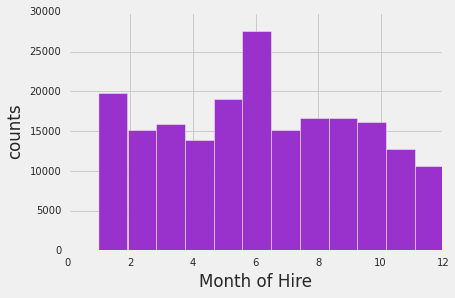

In [68]:
emplxtra_df['hire_month'] = emplxtra_df['HIRE_DT'].apply(lambda x: int(str(x)[5:7]))
emplxtra_df['hire_month'].hist(bins=12,color='darkorchid')
plt.xlabel('Month of Hire')
plt.ylabel('counts')

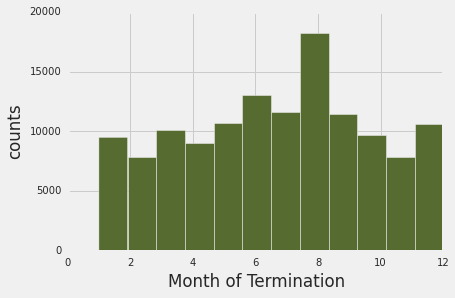

In [69]:
emplxtra_df['term_month'] = emplxtra_df['TERMINATION_DT'].apply(lambda x: int(str(x)[5:7]))
emplxtra_df[emplxtra_df.status==1]['term_month'].hist(bins=12,color='darkolivegreen')#eliminate current employees
plt.xlabel('Month of Termination')
plt.ylabel('counts')

count    199419.000000
mean       1994.719264
std          12.530784
min        1933.000000
25%        1988.000000
50%        1995.000000
75%        2004.000000
max        2014.000000
dtype: float64

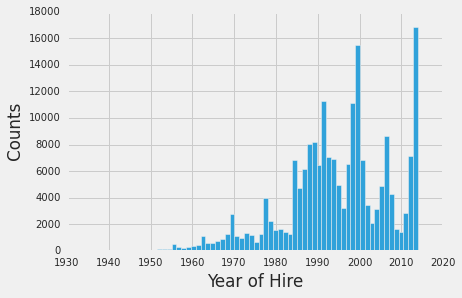

In [70]:
emplxtra_df['hire_year'] = emplxtra_df['HIRE_DT'].apply(lambda x: int(str(x)[:4]))
emplxtra_df.hire_year.hist(bins=70)
plt.xlabel('Year of Hire')
plt.ylabel('Counts')
emplxtra_df.hire_year.describe()

## Back to creating dataframe of Employee Populations as a time series

In [7]:
# create listing where they are timestamps for comparisions
empl_dates = pd.DataFrame()
empl_dates[['hire_tstmp','term_tstmp']] = emplxtra_df[['HIRE_DT','TERMINATION_DT']].apply(lambda x: pd.to_datetime(x))

In [15]:
## construct a range of timestamps between 1st Termination and last termination
monthly_range_terminations = pd.date_range(emplxtra_df.TERMINATION_DT.min(),emplxtra_df.TERMINATION_DT.max(),freq='M')
### Construct a dataframe of # active employees given the end of the month
nactive = []
nsep = []
nhired = []
prev_date = monthly_range_terminations[0]-1
#nsep.append(0.0)
for idx, my_date in enumerate(monthly_range_terminations):
    nactive.append( len(empl_dates[(empl_dates.hire_tstmp < my_date) &(empl_dates.term_tstmp > my_date)]))
    if idx == 0:
        nsep.append(len(empl_dates[(empl_dates.term_tstmp <= my_date) & (empl_dates.hire_tstmp < my_date)]))
        nhired.append( len(empl_dates[(empl_dates.hire_tstmp <= my_date) &(empl_dates.hire_tstmp > prev_date)]))
    else:
        nsep.append(len(empl_dates[(empl_dates.term_tstmp <= my_date) & (empl_dates.hire_tstmp < my_date) &( empl_dates.term_tstmp > monthly_range_terminations[idx-1])]))
        nhired.append( len(empl_dates[(empl_dates.hire_tstmp <= my_date) &(empl_dates.hire_tstmp > monthly_range_terminations[idx-1])]))

In [17]:
workforce = pd.DataFrame(data = nactive, index=monthly_range_terminations,columns=['Active'])
delta = workforce.diff()
workforce['netChange'] = delta
workforce['Separations'] = nsep
workforce['Hires'] = nhired
workforce.head()
                         

,Active,netChange,Separations,Hires
1980-01-31,23444,NaN,1,200
1980-02-29,23574,130,0,129
1980-03-31,23694,120,0,147
1980-04-30,23829,135,0,109
1980-05-31,23934,105,0,104


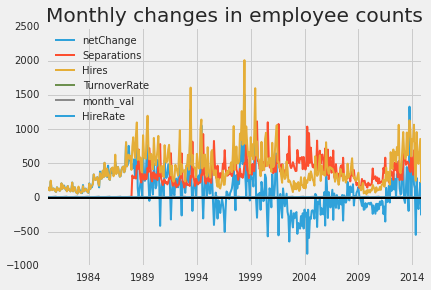

In [71]:
workforce.ix[:,1:].plot()
plt.axhline(0,color='k')
plt.title('Monthly changes in employee counts')

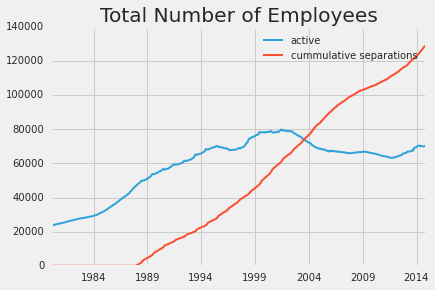

In [72]:
workforce['Active'].plot(label='active')
plt.title('Total Number of Employees')
workforce['Separations'].cumsum().plot(label='cummulative separations')
plt.legend()

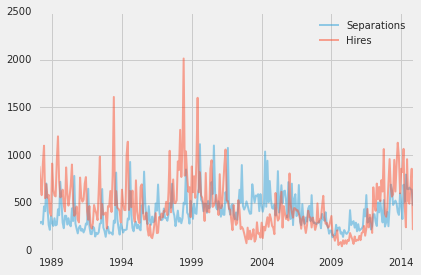

In [73]:
date0 = '1988-01-01'
workforce.ix[date0:,['Separations','Hires']].plot(alpha=0.5)

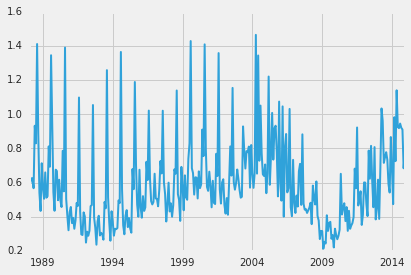

In [74]:
workforce['TurnoverRate'] = workforce['Separations']/workforce['Active']*100.
workforce.TurnoverRate.ix[date0:].plot()

In [29]:
workforce.TurnoverRate.ix[date0:].head()

1988-01-31    0.684018
1988-02-29    0.593827
1988-03-31    0.624261
1988-04-30    0.624742
1988-05-31    0.566636
Freq: M, Name: TurnoverRate, dtype: float64

In [54]:
workforce['HireRate'] = workforce['Hires']/workforce['Active']*100.

In [36]:
workforce['month_val'] = workforce.index.month

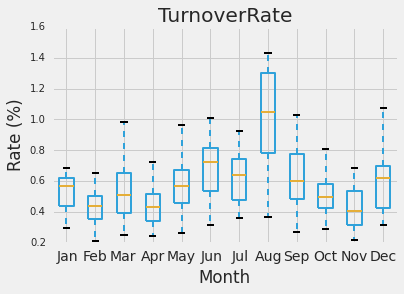

In [223]:
workforce.ix[date0:].boxplot(column='TurnoverRate',by ='month_val')
plt.suptitle("")
plt.xlabel('Month')
plt.xticks(np.arange(1,13),['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct', 'Nov','Dec'])
plt.ylabel('Rate (%)')

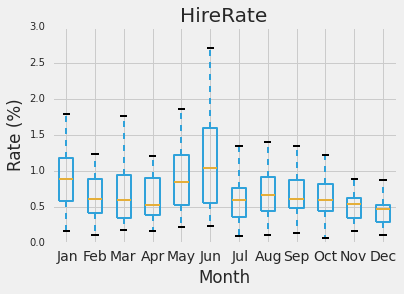

In [222]:
workforce.ix[date0:].boxplot(column='HireRate',by ='month_val')
plt.suptitle("")
plt.xlabel('Month')
plt.xticks(np.arange(1,13),['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct', 'Nov','Dec'])
plt.ylabel('Rate (%)')

In [49]:
## truncate before date0
by_month_wf = workforce.ix[date0:].groupby('month_val')

In [51]:
monthly_mean_values = by_month_wf.aggregate(np.mean)
monthly_std_values = by_month_wf.aggregate(np.std)

## Look at annual numbers (after date0)

In [81]:
annualwf = pd.DataFrame()
after1987 = workforce.ix[date0:].copy()
annualwf= after1987[['Separations','Hires']].resample('A',how='sum')
annualwf['Active'] = after1987['Active'].resample('A',how='last')
annualwf['AnnuTurnoverRate'] = annualwf['Separations']/annualwf['Active']*100.
annualwf['AnnuHireRate'] = annualwf['Hires']/annualwf['Active']*100.

In [82]:
annualwf.head()

,Separations,Hires,Active,AnnuTurnoverRate,AnnuHireRate
1988-12-31,4363,8074,50511,8.637722,15.984637
1989-12-31,4360,8222,54373,8.018686,15.121476
1990-12-31,3990,6473,56813,7.023041,11.393519
1991-12-31,3180,5842,59515,5.343191,9.816013
1992-12-31,2989,5446,61969,4.823379,8.788265


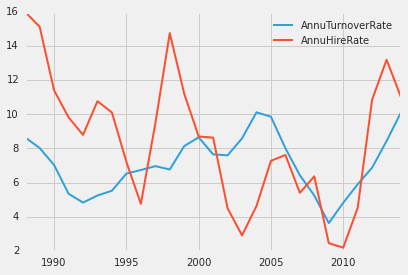

In [83]:
annualwf[['AnnuTurnoverRate','AnnuHireRate']].plot()

# this looks like a good case for implementing Predator-prey models
* The Lotka-Voltera Equations:
$\begin{equation}
\frac{dx}{dt} = \alpha x - \beta xy \\
\frac{dy}{dt} = \delta xy - \gamma y
\end{equation}$
    - where $x$ is the number of one population (hires) and $y$ is the number of the other population (separations)
    - $\alpha$ is the natural growth rate of the first ($x$) population
    - $\beta$ is the natural 'death' rate of this population due to the second population ($y$), i.e. predation
    - $\gamma$ is the natural 'death' rate of the 2nd population, i.e. strength of it's influence on first population.
    - $\delta$ is related to the growth rate of the 2nd population, describing how first population leads to growth of second.

* use scipy odeint

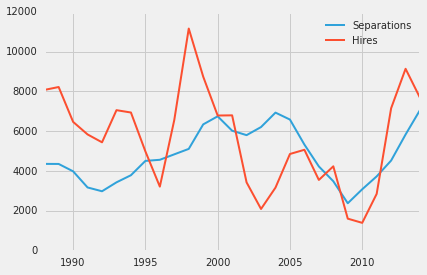

In [85]:
annualwf[['Separations','Hires']].plot()

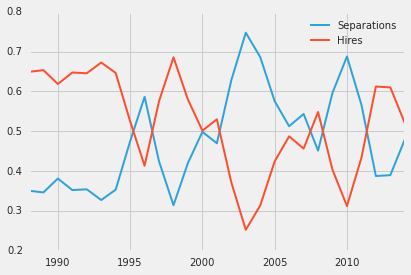

In [120]:
comboPop = annualwf[['Separations','Hires']].sum(axis=1)
annualwf[['Separations','Hires']].apply(lambda x: x/comboPop).plot()

In [100]:
### Define state = ['hires','separations'] as the state of both populations
def lotka_volterra(state, t,params):
    """ Returns the growth rates of the two populations with these input parameters """
    a = params[0]
    b = params[1]
    c = params[2]
    d = params[3]
    pop1 = state[0]
    pop2 = state[1]
    xd = pop1*(a-b*pop2)
    yd = -pop2*(c - d*pop1)
    return [xd,yd]

from scipy.integrate import odeint




In [96]:
x0/float(x0+y0), y0/float(x0+y0)

(0.64919192731366082, 0.35080807268633912)

In [101]:
#define some initial parameters:
my_lv_params = [0.1,0.1,0.1,01.]


In [102]:
state0 = [0.65,0.35]

state = odeint(lotka_volterra,state0,t,args=(my_lv_params,))

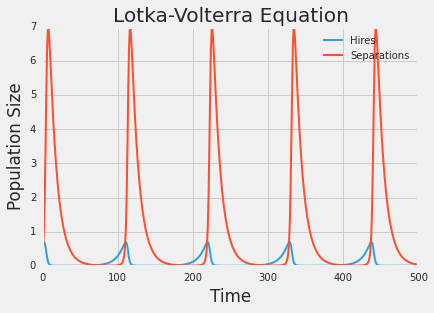

In [103]:
plt.plot(t,state)
plt.ylabel('Population Size')
plt.xlabel('Time')
plt.legend(['Hires','Separations'])
plt.title('Lotka-Volterra Equation')

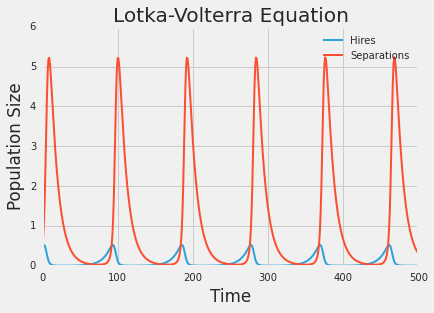

In [107]:
state0 = [0.5,0.5]

state = odeint(lotka_volterra,state0,t, args=(my_lv_params,))
plt.plot(t,state)
plt.ylabel('Population Size')
plt.xlabel('Time')
plt.legend(['Hires','Separations'])
plt.title('Lotka-Volterra Equation')

In [125]:
#from scipy import odeint
my_time = np.linspace(0,100,1000)
x0 = annualwf['Hires'].iloc[0]
y0 = annualwf['Separations'].iloc[0] 
    

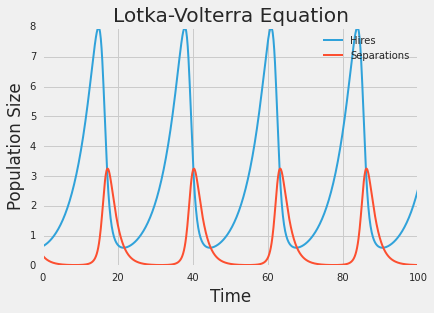

In [126]:
state = odeint(lotka_volterra,[0.65,0.35],my_time, args=([0.2,0.3,0.6,0.21],))
plt.plot(my_time,state)
plt.ylabel('Population Size')
plt.xlabel('Time')
plt.legend(['Hires','Separations'])
plt.title('Lotka-Volterra Equation')

IndexError: index 1000 is out of bounds for axis 0 with size 1000

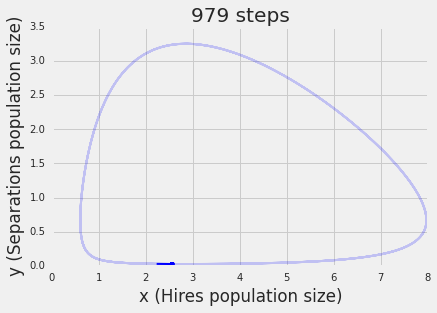

In [127]:
# animation in state-space
plt.figure()
pb, = plt.plot(state[:,0],state[:,1],'b-',alpha=0.2)
plt.xlabel('x (Hires population size)')
plt.ylabel('y (Separations population size)')
p, = plt.plot(state[0:10,0],state[0:10,1],'b-')
pp, = plt.plot(state[10,0],state[10,1],'b.',markersize=10)
tt = plt.title("%4.2f sec" % 0.00)

# animate
step=2
for i in xrange(1,len(state)-10,step):
  p.set_xdata(state[10+i:20+i,0])
  p.set_ydata(state[10+i:20+i,1])
  pp.set_xdata(state[19+i,0])
  pp.set_ydata(state[19+i,1])
  tt.set_text("%d steps" % (i))
  plt.draw()

## back to annual turnover rates

1988-12-31 00:00:00


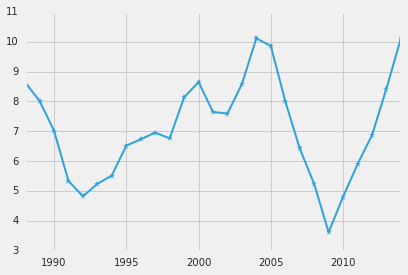

In [130]:
annualwf['AnnuTurnoverRate'].plot(marker='*')
print annualwf.index[0]

In [131]:
### load in the federal unemployment data
unempl_raw = pd.read_csv('us_unemployment_monthly_seas.csv')
unempl_raw.head()

,Year,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
0,1987,6.6,6.6,6.6,6.3,6.3,6.2,6.1,6.0,5.9,6.0,5.8,5.7
1,1988,5.7,5.7,5.7,5.4,5.6,5.4,5.4,5.6,5.4,5.4,5.3,5.3
2,1989,5.4,5.2,5.0,5.2,5.2,5.3,5.2,5.2,5.3,5.3,5.4,5.4
3,1990,5.4,5.3,5.2,5.4,5.4,5.2,5.5,5.7,5.9,5.9,6.2,6.3
4,1991,6.4,6.6,6.8,6.7,6.9,6.9,6.8,6.9,6.9,7.0,7.0,7.3


In [144]:
unempl = pd.melt(unempl_raw, id_vars='Year')
unempl.sort('Year',inplace=True)
# define a dictionary

In [156]:
#unempl['date'] =
unempl['date'] = unempl[['Year','variable']].apply(lambda x: pd.to_datetime(x[1]+str(x[0]),format='%b%Y'),axis=1)
unempl.sort('date',inplace=True)
print len(unempl), len(workforce)
unempl.head()

348 420


,Year,variable,value,date
0,1987,Jan,6.6,1987-01-01
29,1987,Feb,6.6,1987-02-01
58,1987,Mar,6.6,1987-03-01
87,1987,Apr,6.3,1987-04-01
116,1987,May,6.3,1987-05-01


In [159]:
unempl_tshift = pd.Series(unempl.date)
unempl.index = unempl_tshift.map(lambda x: x+ pd.tseries.offsets.MonthEnd())

In [ ]:
avg_unempl

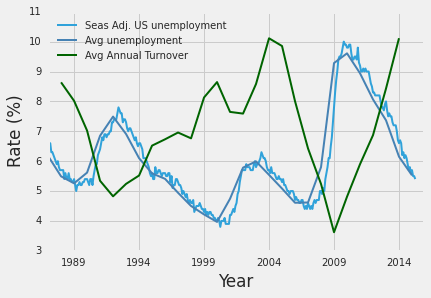

In [192]:
unempl['value'].plot(label='Seas Adj. US unemployment')
plt.ylabel('Rate (%)')
avg_unempl.plot(label='Avg unemployment',color='steelblue')
#plt.plot(avg_unempl.index,avg_unempl.values,label='Avg unemployment')
annualwf.AnnuTurnoverRate.plot(label='Avg Annual Turnover',color='darkgreen')

plt.legend(loc=2)
plt.xlabel('Year')

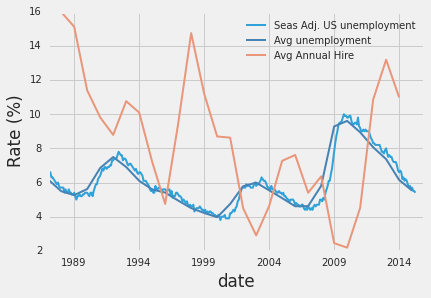

In [211]:
unempl['value'].plot(label='Seas Adj. US unemployment')
avg_unempl.plot(label='Avg unemployment',color='steelblue')
plt.ylabel('Rate (%)')
annualwf.AnnuHireRate.plot(label='Avg Annual Hire', color='darksalmon')
plt.legend()

In [168]:
avg_unempl = unempl['value'].resample('A', how='mean')

In [187]:
avg_unempl.index+1

<class 'pandas.tseries.index.DatetimeIndex'>
[1988-12-31, ..., 2016-12-31]
Length: 29, Freq: A-DEC, Timezone: None

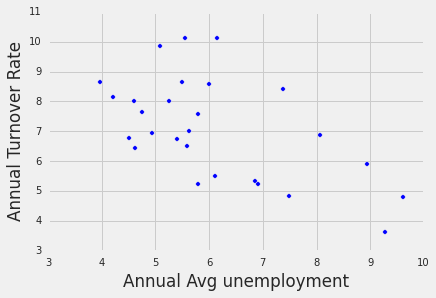

In [194]:
plt.scatter(avg_unempl.ix[1:-1].values, annualwf.AnnuTurnoverRate.values)
plt.xlabel('Annual Avg unemployment')
plt.ylabel('Annual Turnover Rate')

In [177]:
np.corrcoef([avg_unempl.ix[2:].values,annualwf.AnnuTurnoverRate.values])

array([[ 1.        , -0.68210595],
       [-0.68210595,  1.        ]])

In [203]:
from sklearn.linear_model import LinearRegression
from sklearn import metrics
lm = LinearRegression()
ann_turnover = annualwf.AnnuTurnoverRate.values

ann_unempl = avg_unempl.ix[1:-1].values
ann_unempl2 = (np.vstack([ann_unempl, np.ones(len(ann_unempl))])).T
print len(ann_turnover), len(ann_unempl2)

27 27


In [204]:
lm.fit(ann_unempl2,ann_turnover)
print lm.intercept_
print lm.coef_
r2 = metrics.r2_score(ann_unempl2[:,0],ann_turnover)
print r2

10.8905358102
[-0.62520026  0.        ]
-2.94960278539


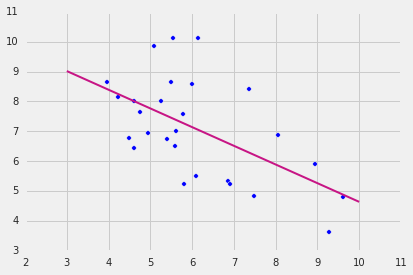

In [208]:
plt.scatter(ann_unempl,ann_turnover)
xx = np.linspace(3,10,60)
yy = lm.intercept_+lm.coef_[0]*xx
plt.plot(xx,yy,color='mediumvioletred')

In [215]:
date0

'1988-01-01'

## Back to the turnover/separation rate..

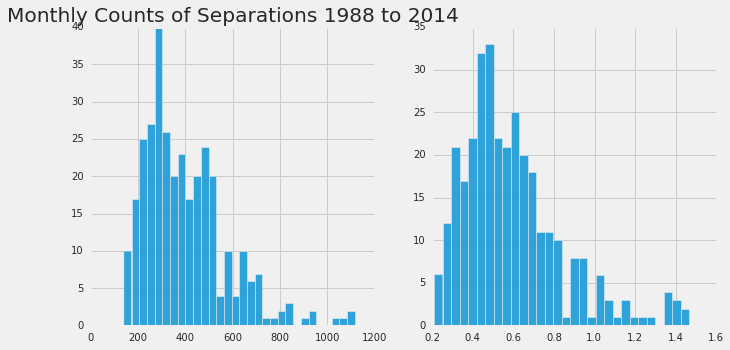

In [226]:
plt.figure(figsize=(10,5))
plt.subplot(121)
workforce.ix[date0:].Separations.hist(bins=30)
plt.title('Monthly Counts of Separations 1988 to 2014')
plt.subplot(122)
workforce.ix[date0:].TurnoverRate.hist(bins=30)

count    27.000000
mean      7.094760
std       1.702376
min       3.621715
25%       5.708491
50%       6.958333
75%       8.280653
max      10.114627
dtype: float64

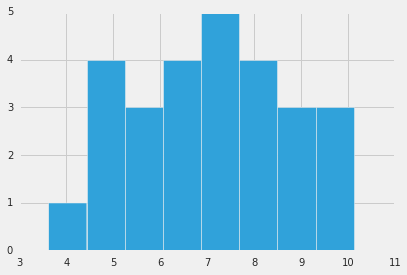

In [237]:
annualwf.AnnuTurnoverRate.hist(bins=8)
annualwf.AnnuTurnoverRate.describe()

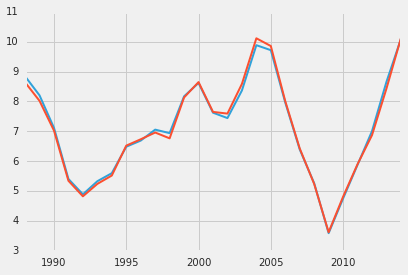

In [229]:
annualwf['SumTurnover'] = after1987['TurnoverRate'].resample('A',how='sum')
annualwf.SumTurnover.plot()
annualwf.AnnuTurnoverRate.plot()
# don't try to use median value of the monthly 

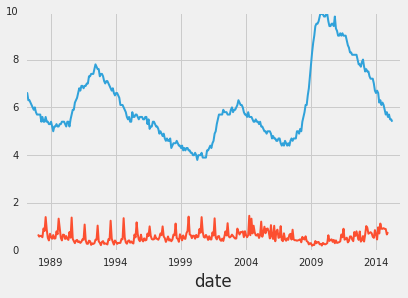

In [232]:
unempl.value.plot()
after1987.TurnoverRate.plot()

## Are there differences in sub-populations?
## Can I weight the turnover by employee salaries?
## what is the impact of discounting retirees?

In [239]:
pd.crosstab(emplxtra_df.retired,emplxtra_df.sep_status)

sep_status,0,1,2,3
retired,,,,
0,69805,71766,34020,820
1,1,18289,4718,0


In [247]:
workforce.ix['2014-02-28']

Active          70141.000000
netChange         491.000000
Separations       332.000000
Hires             823.000000
TurnoverRate        0.473332
month_val           2.000000
HireRate            1.173351
Name: 2014-02-28 00:00:00, dtype: float64

In [244]:
emplxtra_df.ix[:30][['SAL1','Age_years','Tenure_years']].apply(np.median).values

array([  4.19969000e+04,   3.45879792e+01,   8.92010103e+00])

In [381]:
ssvc = emplxtra_df.ix[empl_dates[(empl_dates.term_tstmp <= '2014-02-28') & (empl_dates.term_tstmp > '2014-01-31')].index].sep_status.value_counts()
ssvc.loc[2]

73

In [250]:
## add in some counts of retirees
## construct a range of timestamps between 1st Termination and last termination
#monthly_range_terminations = pd.date_range(emplxtra_df.TERMINATION_DT.min(),emplxtra_df.TERMINATION_DT.max(),freq='M')
### Construct a dataframe of # active employees given the end of the month
nretired = []
prev_date = monthly_range_terminations[0]-1
median_values = []
for idx, my_date in enumerate(monthly_range_terminations):
    mthly_active_idx = empl_dates[(empl_dates.hire_tstmp < my_date) &(empl_dates.term_tstmp > my_date)].index
    median_values.append(emplxtra_df.ix[mthly_active_idx][['SAL1','Age_years','Tenure_years']].apply(np.median).values)
    # calculate the monthly median values and append them to an array.
    if idx == 0:
        nretired.append(emplxtra_df.ix[empl_dates[(empl_dates.term_tstmp <=my_date) & (empl_dates.term_tstmp > my_date)].index].retired.sum())

    else:
        nretired.append(emplxtra_df.ix[empl_dates[(empl_dates.term_tstmp <=my_date) & (empl_dates.term_tstmp >  monthly_range_terminations[idx-1]) & (empl_dates.hire_tstmp < my_date)].index].retired.sum())


In [385]:
idx,ssvc,my_date,mthly_active_idx

(1,
 Series([], dtype: int64),
 Timestamp('1980-02-29 00:00:00', offset='M'),
 Int64Index([0, 2, 3, 11, 23, 25, 44, 48, 57, 66, 106, 110, 113, 120, 135, 149, 161, 166, 173, 181, 183, 227, 232, 241, 242, 243, 245, 247, 251, 256, 262, 273, 293, 296, 313, 314, 319, 327, 328, 329, 336, 349, 354, 366, 372, 373, 384, 388, 393, 398, 399, 401, 402, 406, 411, 417, 433, 447, 457, 461, 470, 474, 480, 485, 488, 517, 519, 533, 536, 569, 574, 591, 595, 598, 610, 613, 614, 616, 624, 631, 640, 642, 646, 655, 664, 687, 689, 691, 709, 714, 720, 721, 728, 733, 734, 741, 747, 751, 755, 788, ...], dtype='int64'))

In [393]:
## add in some counts of retirees
## construct a range of timestamps between 1st Termination and last termination
#monthly_range_terminations = pd.date_range(emplxtra_df.TERMINATION_DT.min(),emplxtra_df.TERMINATION_DT.max(),freq='M')
### Construct a dataframe of # active employees given the end of the month
nvol = []
ninvol = []
prev_date = monthly_range_terminations[0]-1

for idx, my_date in enumerate(monthly_range_terminations):
    mthly_active_idx = empl_dates[(empl_dates.hire_tstmp < my_date) &(empl_dates.term_tstmp > my_date)].index
    #median_values.append(emplxtra_df.ix[mthly_active_idx][['SAL1','Age_years','Tenure_years']].apply(np.median).values)
    # calculate the monthly median values and append them to an array.
    if idx == 0:
        ssvc = emplxtra_df.ix[mthly_active_idx].sep_status.value_counts()
        
    else:
        active = emplxtra_df.ix[empl_dates[(empl_dates.term_tstmp <=my_date) & (empl_dates.term_tstmp >  monthly_range_terminations[idx-1]) & (empl_dates.hire_tstmp < my_date)].index]
        ssvc = active.sep_status.value_counts()
        
    try:
        nvol.append(ssvc.loc[1])
    except KeyError:
        nvol.append(0)
        
    try:
        ninvol.append(ssvc.loc[2])
    except KeyError:
        ninvol.append(0)


In [396]:
workforce['Invol'] = ninvol
workforce['Vol'] = nvol

In [389]:
print len(emplxtra_df.ix[mthly_active_idx]), my_date
emplxtra_df.ix[mthly_active_idx].sep_status.value_counts()

23574 1980-02-29 00:00:00


1    14074
2     5744
0     3643
3      113
dtype: int64

In [391]:
len(emplxtra_df.ix[empl_dates[(empl_dates.term_tstmp <=my_date) & (empl_dates.term_tstmp >  monthly_range_terminations[idx-1]) & (empl_dates.hire_tstmp < my_date)].index])

0

In [400]:
workforce.iloc[0,-2:] = [np.nan,np.nan] # replace initial values because they're hinky

In [251]:
workforce['Retired'] = nretired
np.shape(median_values)

(420, 3)

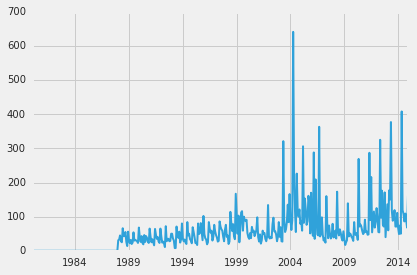

In [252]:
workforce.Retired.plot()

In [263]:
workforce['medianSalary'] = np.array(median_values).flatten()[::3]
workforce['medianAge'] = np.array(median_values).flatten()[1::3]
workforce['medianTenure'] = np.array(median_values).flatten()[2::3]

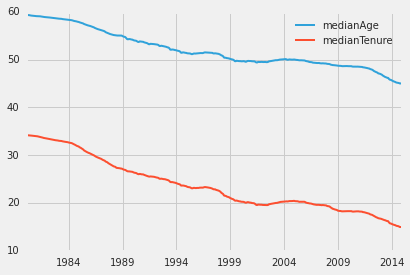

In [264]:
workforce[['medianAge','medianTenure']].plot()

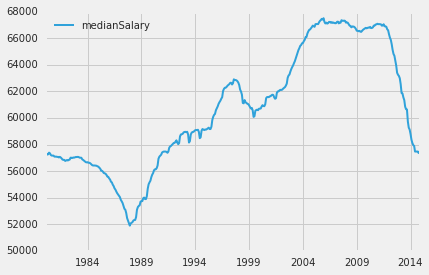

In [265]:
workforce[['medianSalary']].plot()

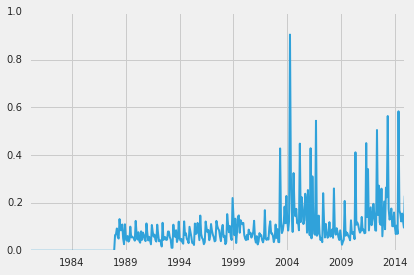

In [266]:
workforce['RetireRate'] = workforce['Retired']/workforce['Active']*100.
workforce.RetireRate.plot()

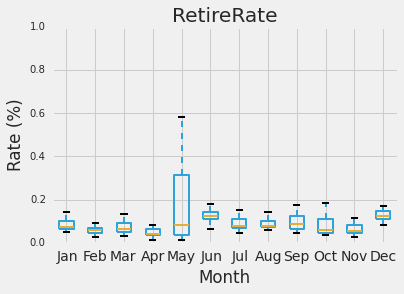

In [267]:
workforce.ix[date0:].boxplot(column='RetireRate',by ='month_val')
plt.suptitle("")
plt.xlabel('Month')
plt.xticks(np.arange(1,13),['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct', 'Nov','Dec'])
plt.ylabel('Rate (%)')

### redefine Turnover as Separation - Retire

In [269]:
workforce['Turnover'] = workforce['Separations'] - workforce['Retired']
workforce['SeparationRate'] = workforce['TurnoverRate']
workforce['TurnoverRate'] = workforce['Turnover']/workforce['Active']*100.

In [401]:
workforce['VolSepRate'] = workforce['Vol']/workforce['Active']*100.
workforce['InvolSepRate'] = workforce['Invol']/workforce['Active']*100.

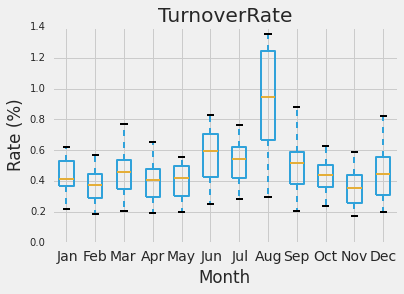

In [270]:
workforce.ix[date0:].boxplot(column='TurnoverRate',by ='month_val')
plt.suptitle("")
plt.xlabel('Month')
plt.xticks(np.arange(1,13),['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct', 'Nov','Dec'])
plt.ylabel('Rate (%)')

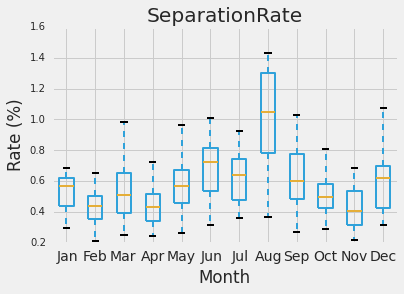

In [271]:
workforce.ix[date0:].boxplot(column='SeparationRate',by ='month_val')
plt.suptitle("")
plt.xlabel('Month')
plt.xticks(np.arange(1,13),['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct', 'Nov','Dec'])
plt.ylabel('Rate (%)')

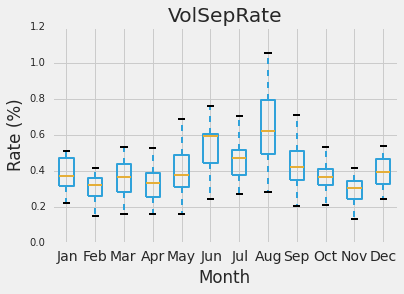

In [402]:
workforce.ix[date0:].boxplot(column='VolSepRate',by ='month_val')
plt.suptitle("")
plt.xlabel('Month')
plt.xticks(np.arange(1,13),['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct', 'Nov','Dec'])
plt.ylabel('Rate (%)')

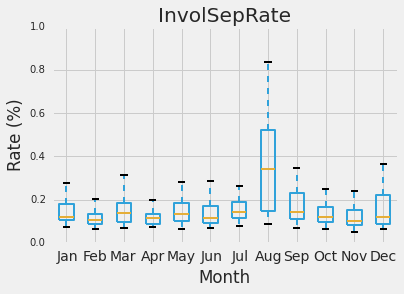

In [403]:
workforce.ix[date0:].boxplot(column='InvolSepRate',by ='month_val')
plt.suptitle("")
plt.xlabel('Month')
plt.xticks(np.arange(1,13),['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct', 'Nov','Dec'])
plt.ylabel('Rate (%)')

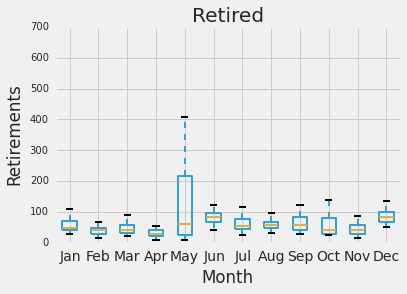

In [418]:
workforce.ix[date0:].boxplot(column='Retired',by ='month_val')
plt.suptitle("")
plt.xlabel('Month')
plt.xticks(np.arange(1,13),['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct', 'Nov','Dec'])
plt.ylabel('Retirements')

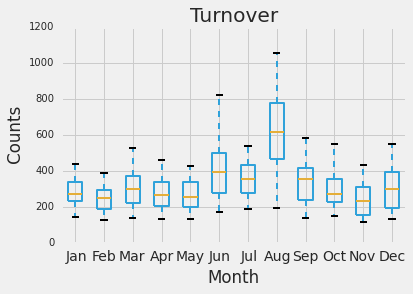

In [419]:
workforce.ix[date0:].boxplot(column='Turnover',by ='month_val')
plt.suptitle("")
plt.xlabel('Month')
plt.xticks(np.arange(1,13),['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct', 'Nov','Dec'])
plt.ylabel('Counts')

In [273]:
workforce['NetChangeRate'] = workforce['netChange']/workforce['Active']*100.

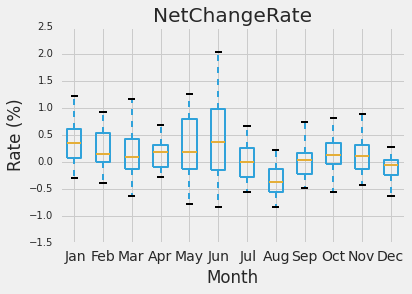

In [275]:
workforce.ix[date0:].boxplot(column='NetChangeRate',by ='month_val')
plt.suptitle("")
plt.xlabel('Month')
plt.xticks(np.arange(1,13),['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct', 'Nov','Dec'])
plt.ylabel('Rate (%)')

In [404]:
workforce.tail()

,Active,netChange,Separations,Hires,TurnoverRate,month_val,HireRate,Retired,medianSalary,medianAge,medianTenure,RetireRate,Turnover,SeparationRate,NetChangeRate,year,Invol,Vol,VolSepRate,InvolSepRate
2014-08-31,69938,-169,661,492,0.822157,8,0.703480,86,57474.00,45.153562,15.168005,0.122966,575,0.945123,-0.241643,2014,105,555,0.793560,0.150133
2014-09-30,69980,42,644,686,0.764504,9,0.980280,109,57474.00,45.090590,15.091343,0.155759,535,0.920263,0.060017,2014,147,496,0.708774,0.210060
2014-10-31,70199,219,639,858,0.782062,10,1.222240,90,57364.65,45.005715,14.976351,0.128207,549,0.910269,0.311970,2014,174,463,0.659554,0.247867
2014-11-30,69946,-253,478,225,0.586166,11,0.321677,68,57474.00,45.016667,14.976351,0.097218,410,0.683384,-0.361708,2014,120,355,0.507534,0.171561
2014-12-31,69879,-67,546,479,0.550952,12,0.685471,161,57474.00,44.950957,14.938021,0.230398,385,0.781351,-0.095880,2014,170,375,0.536642,0.243278


In [284]:
workforce['year'] = [int(str(x)[:4]) for x in list(workforce.index)]

(0, 0.4)

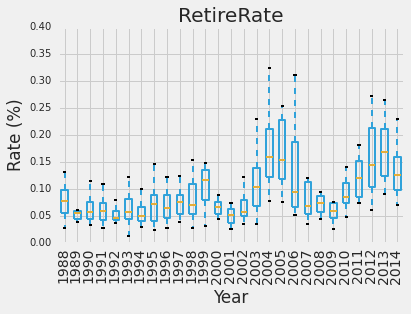

In [287]:
workforce.ix[date0:].boxplot(column='RetireRate',by ='year')
plt.suptitle("")
plt.xlabel('Year')
#plt.xticks(np.arange(1,13),['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct', 'Nov','Dec'])
plt.ylabel('Rate (%)')
plt.xticks( rotation='vertical')
plt.ylim(0,0.4)

In [405]:
workforce.columns

Index([u'Active', u'netChange', u'Separations', u'Hires', u'TurnoverRate', u'month_val', u'HireRate', u'Retired', u'medianSalary', u'medianAge', u'medianTenure', u'RetireRate', u'Turnover', u'SeparationRate', u'NetChangeRate', u'year', u'Invol', u'Vol', u'VolSepRate', u'InvolSepRate'], dtype='object')

## recalculate the annual values now that I have more data

In [406]:
annualwf = pd.DataFrame()
after1987 = workforce.ix[date0:].copy()
annualwf= after1987[['Separations','Hires','Retired','Turnover','Vol','Invol']].resample('A',how='sum')
annualwf['Active'] = after1987['Active'].resample('A',how='last')
annualwf['AnnuSeparationRate'] = annualwf['Separations']/annualwf['Active']*100.
annualwf['AnnuTurnoverRate'] = annualwf['Turnover']/annualwf['Active']*100.
annualwf['AnnuHireRate'] = annualwf['Hires']/annualwf['Active']*100.
annualwf['AnnuRetireRate'] = annualwf['Retired']/annualwf['Active']*100.
annualwf['AnnuVolSepRate'] = annualwf['Vol']/annualwf['Active']*100.
annualwf['AnnuInvolSepRate'] = annualwf['Invol']/annualwf['Active']*100.

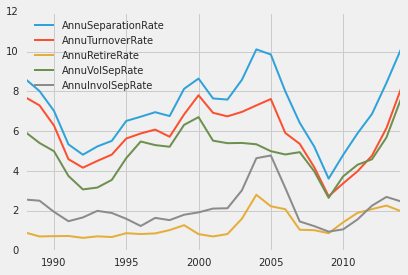

In [409]:
annualwf[['AnnuSeparationRate','AnnuTurnoverRate','AnnuRetireRate','AnnuVolSepRate','AnnuInvolSepRate']].plot()#kind='bar')

In [422]:
annualwf['year'] = [int(str(x)[:4]) for x in list(annualwf.index)]

([<matplotlib.axis.XTick at 0x7ff87a1af610>,
 <a list of 27 Text xticklabel objects>)

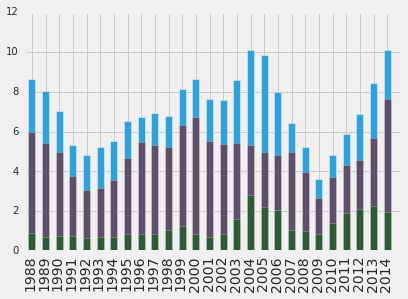

In [425]:
annualwf['AnnuSeparationRate'].plot(kind='bar')
annualwf['AnnuVolSepRate'].plot(kind='bar',color='darkred',alpha=0.5)
annualwf['AnnuRetireRate'].plot(kind='bar',color='darkgreen',alpha=0.5)
plt.xticks(np.arange(0,28),annualwf.year)

([<matplotlib.axis.XTick at 0x7ff8780e73d0>,
 <a list of 27 Text xticklabel objects>)

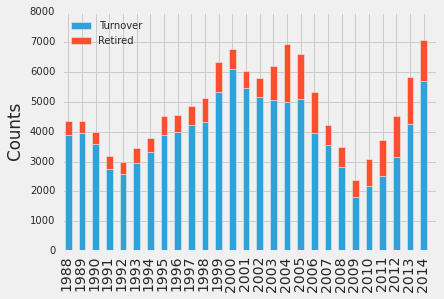

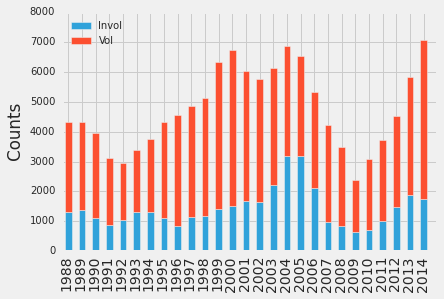

In [433]:
#annualwf['Separations'].plot(kind='bar')
#plt.figure(figsize=(18,9))
#plt.subplot(121)
annualwf[['Turnover','Retired']].plot(kind='bar', stacked=True)
plt.xticks(np.arange(0,28),annualwf.year)
plt.ylabel('Counts')
#plt.subplot(122)
annualwf[['Invol','Vol']].plot(kind='bar', stacked=True)
plt.ylabel('Counts')
#annualwf['AnnuVolSepRate'].plot(kind='bar',color='darkred',alpha=0.5)
#annualwf['AnnuRetireRate'].plot(kind='bar',color='darkgreen',alpha=0.5)
plt.xticks(np.arange(0,28),annualwf.year)

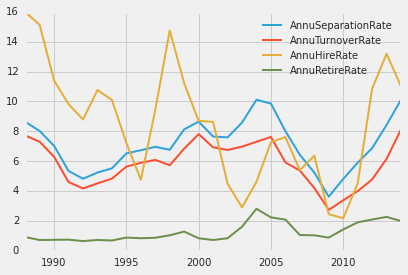

In [277]:
annualwf[['AnnuSeparationRate','AnnuTurnoverRate','AnnuHireRate','AnnuRetireRate']].plot()

1.25642607736 3.85234395706


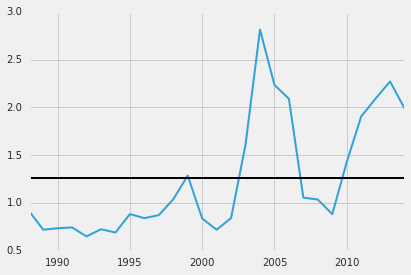

In [297]:
annualwf['AnnuRetireRate'].plot()
meanAnnRetireRate = annualwf.AnnuRetireRate.mean()
err = annualwf.AnnuHireRate.std()
plt.axhline(meanAnnRetireRate,color='k')
#plt.axhspan(meanAnnRetireRate-0.95*err, meanAnnRetireRate+0.95*err,facecolor='lightgreen',alpha=0.4)
print meanAnnRetireRate, err

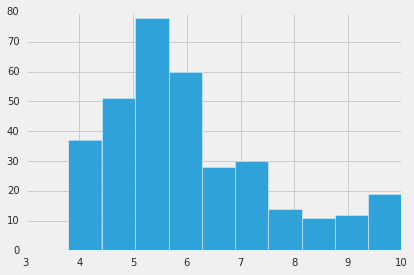

In [302]:
unempl.value.hist()

In [306]:
unempl.head()

,Year,variable,value,date
date,,,,
1987-01-31,1987,Jan,6.6,1987-01-01
1987-02-28,1987,Feb,6.6,1987-02-01
1987-03-31,1987,Mar,6.6,1987-03-01
1987-04-30,1987,Apr,6.3,1987-04-01
1987-05-31,1987,May,6.3,1987-05-01


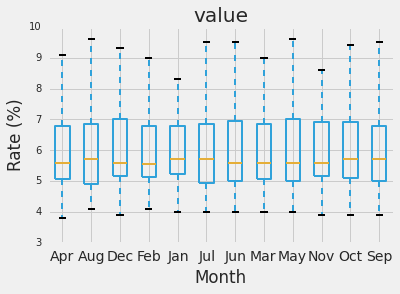

In [304]:
unempl.ix[date0:].boxplot(column='value',by ='variable')
plt.suptitle("")
plt.xlabel('Month')
#plt.xticks(np.arange(1,13),['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct', 'Nov','Dec'])
plt.ylabel('Rate (%)')
#plt.xticks( rotation='vertical')


(array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]),
 <a list of 28 Text xticklabel objects>)

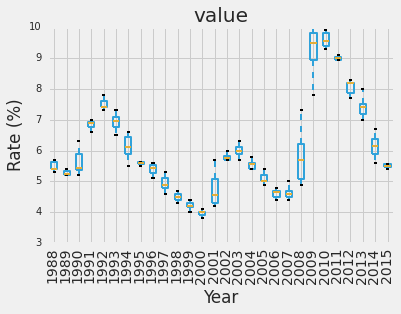

In [311]:
unempl.ix[date0:].boxplot(column='value',by ='Year')
plt.suptitle("")
plt.xlabel('Year')
#plt.xticks(np.arange(1,13),['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct', 'Nov','Dec'])
plt.ylabel('Rate (%)')
plt.xticks( rotation='vertical')

In [312]:
annualwf.AnnuSeparationRate.values, 

array([  8.63772248,   8.01868574,   7.0230405 ,   5.34319079,
         4.82337943,   5.23948901,   5.51902712,   6.51969778,
         6.73178925,   6.95833333,   6.76361713,   8.13172732,
         8.64637098,   7.64868568,   7.59172573,   8.58414172,
        10.1122449 ,   9.8532777 ,   8.00630536,   6.42523364,
         5.23679554,   3.62171512,   4.80980334,   5.89795403,
         6.87035633,   8.42957787,  10.11462671])

In [313]:
med_unempl = unempl['value'].resample('A',how='median')
avg_unempl = unempl['value'].resample('A', how='mean')
med_unempl.head()

date
1987-12-31    6.15
1988-12-31    5.40
1989-12-31    5.25
1990-12-31    5.45
1991-12-31    6.90
Freq: A-DEC, Name: value, dtype: float64

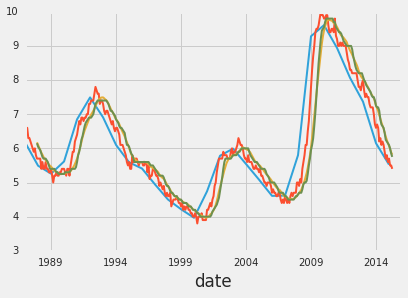

In [323]:
#med_unempl.plot()
avg_unempl.plot()
unempl.value.plot()
pd.rolling_mean(unempl.value,window=12).plot()
pd.rolling_median(unempl.value,window=12).plot()

In [328]:
r12avg = pd.rolling_mean(unempl.value,window=12)
avg_r12mean = r12avg.resample('A',how='mean')
#avg_unempl.plot()

In [331]:
print len(avg_r12mean),len(annualwf.AnnuTurnoverRate)
avg_r12mean.head()

29 27


date
1987-12-31    6.175000
1988-12-31    5.755556
1989-12-31    5.315278
1990-12-31    5.375000
1991-12-31    6.322222
Freq: A-DEC, dtype: float64

In [332]:
np.corrcoef([avg_r12mean.ix[1:-1].values,annualwf.AnnuTurnoverRate.values])

array([[ 1.        , -0.61180722],
       [-0.61180722,  1.        ]])

In [345]:
ann_avg_unempl = avg_r12mean.ix[1:-1].values
ann_avg_turnover = annualwf.AnnuTurnoverRate.values
print np.shape(ann_avg_unempl), np.shape(ann_avg_turnover)
tmp = np.vstack([ann_avg_turnover,np.zeros(len(ann_avg_turnover))]).T
print np.shape(tmp)

(27,) (27,)
(27, 2)


In [351]:
import statsmodels.api as sm
tmp = ann_avg_unempl
tmp = sm.add_constant(tmp)
olsresults = sm.OLS(ann_avg_turnover,tmp).fit()

In [352]:
olsresults.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.374
Model:                            OLS   Adj. R-squared:                  0.349
Method:                 Least Squares   F-statistic:                     14.96
Date:                Fri, 15 May 2015   Prob (F-statistic):           0.000696
Time:                        10:13:51   Log-Likelihood:                -41.582
No. Observations:                  27   AIC:                             87.16
Df Residuals:                      25   BIC:                             89.76
Df Model:                           1                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const          9.4422      0.959      9.847      0.000         7.467    11.417
x1            -0.5935      0.153     -3.867      0.001        -0.910    -0.277
==============================================================================
Omnibus:                        0.205   Durbin-Watson:                   0.511
Prob(Omnibus):                  0.903   Jarque-Bera (JB):                0.154
Skew:                           0.153   Prob(JB):                        0.926
Kurtosis:                       2.791   Cond. No.                         27.2
==============================================================================
"""

In [353]:
olsresults.params

array([ 9.4422076, -0.5935117])

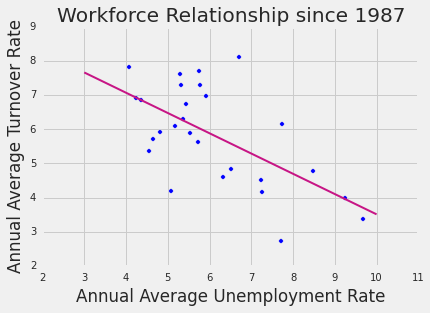

In [354]:
plt.scatter(ann_avg_unempl,ann_avg_turnover)
xx = np.linspace(3,10,60)
yy = olsresults.params[0]+olsresults.params[1]*xx
plt.plot(xx,yy,color='mediumvioletred')
plt.xlabel('Annual Average Unemployment Rate')
plt.ylabel('Annual Average Turnover Rate')
plt.title('Workforce Relationship since 1987')

In [435]:
## repeat using seaborn
annual = pd.concat([annualwf,pd.DataFrame(avg_r12mean)],axis=1)
annual.dropna(axis=0,inplace=True)
annual.rename(columns={0: 'avgUnempl'},inplace=True)
annual.head()

,Separations,Hires,Retired,Turnover,Vol,Invol,Active,AnnuSeparationRate,AnnuTurnoverRate,AnnuHireRate,AnnuRetireRate,AnnuVolSepRate,AnnuInvolSepRate,year,avgUnempl
date,,,,,,,,,,,,,,,
1988-12-31,4363,8074,465,3898,3017,1300,50511,8.637722,7.717131,15.984637,0.920592,5.972956,2.573697,1988,5.755556
1989-12-31,4360,8222,392,3968,2943,1368,54373,8.018686,7.297740,15.121476,0.720946,5.412613,2.515955,1989,5.315278
1990-12-31,3990,6473,418,3572,2840,1111,56813,7.023041,6.287293,11.393519,0.735747,4.998856,1.955538,1990,5.375000
1991-12-31,3180,5842,443,2737,2236,884,59515,5.343191,4.598841,9.816013,0.744350,3.757036,1.485340,1991,6.322222
1992-12-31,2989,5446,403,2586,1910,1038,61969,4.823379,4.173054,8.788265,0.650325,3.082186,1.675031,1992,7.247917


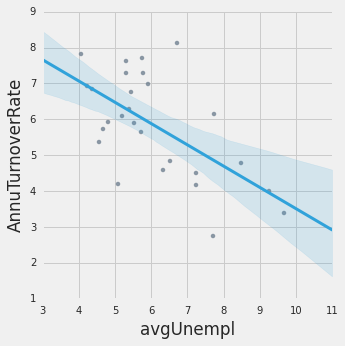

In [371]:
sns.lmplot('avgUnempl','AnnuTurnoverRate',annual,
          scatter_kws={'marker':'.',"color":"slategray"})

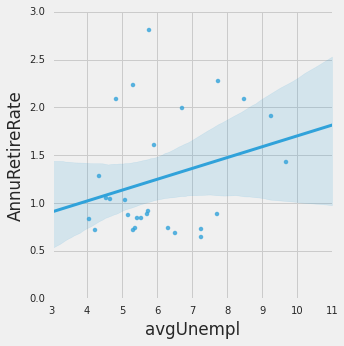

In [373]:
sns.lmplot('avgUnempl','AnnuRetireRate',annual)

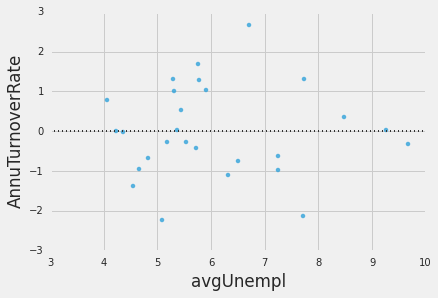

In [374]:
sns.residplot(annual.avgUnempl,annual.AnnuTurnoverRate);

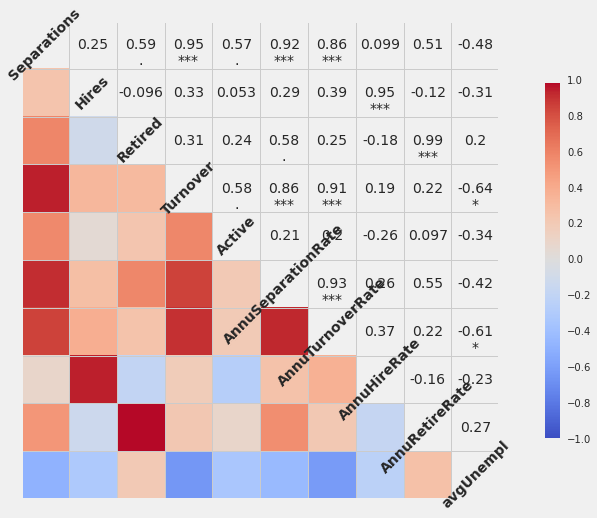

In [377]:
plt.figure(figsize=(14,8))
sns.corrplot(annual);

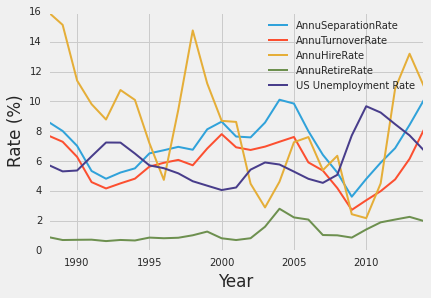

In [440]:
#annualwf.columns
annual[['AnnuSeparationRate','AnnuTurnoverRate','AnnuHireRate','AnnuRetireRate']].plot()
annual['avgUnempl'].plot(color='darkslateblue',label='US Unemployment Rate')
plt.legend()
plt.xlabel('Year')
plt.ylabel('Rate (%)')

In [441]:
annualwf.tail()

,Separations,Hires,Retired,Turnover,Vol,Invol,Active,AnnuSeparationRate,AnnuTurnoverRate,AnnuHireRate,AnnuRetireRate,AnnuVolSepRate,AnnuInvolSepRate,year
2010-12-31,3089,1403,917,2172,2398,691,64223,4.809803,3.381966,2.184576,1.427837,3.733865,1.075939,2010
2011-12-31,3736,2858,1207,2529,2736,998,63344,5.897954,3.992485,4.511872,1.905469,4.319273,1.575524,2011
2012-12-31,4531,7156,1380,3151,3031,1494,65950,6.870356,4.777862,10.850644,2.092494,4.595906,2.265353,2012
2013-12-31,5839,9137,1573,4266,3941,1874,69268,8.429578,6.158688,13.190795,2.270890,5.689496,2.705434,2013
2014-12-31,7068,7679,1390,5678,5325,1733,69879,10.114627,8.125474,10.988995,1.989153,7.620315,2.480001,2014


In [442]:
import datetime
today = datetime.date.today()
today

datetime.date(2015, 5, 21)

In [445]:
now = datetime.datetime.now()
now

datetime.datetime(2015, 5, 21, 10, 42, 5, 470485)

In [443]:
t1 = pd.to_datetime('2005-01-01')
t1

Timestamp('2005-01-01 00:00:00')

In [452]:
t2 = pd.to_datetime('2010-01-01')
t2

Timestamp('2010-01-01 00:00:00')

In [446]:
now - t1

datetime.timedelta(3792, 38525, 470485)

In [449]:
datetime.timedelta(weeks=52)

datetime.timedelta(364)

In [461]:
np.round((t2-t1).total_seconds()/(60.*60.*24.*365.245),0)#/np.timedelta64(1,'Y')

5.0

In [464]:
mxt = pd.to_datetime('2015-01-01')
(t2+datetime.timedelta(5*365.25))

Timestamp('2015-01-01 06:00:00')

In [470]:
(datetime.date(2010,1,1) - datetime.date(2005,1,1) + datetime.date(2010,1,1)) == datetime.date(2015,1,1)

True

In [472]:
sum(empl_dates.hire_tstmp > datetime.date(2010,1,1))

28231

In [478]:
dstr = '2010-01-01'
estr = '2012-01-01'
d_date = datetime.date(int(dstr[:4]),int(dstr[5:7]),int(dstr[-2:]))
e_date = datetime.date(int(estr[:4]),int(estr[5:7]),int(estr[-2:]))
(e_date-d_date)

datetime.timedelta(730)

In [488]:
from datetime import date

def add_years(d, years):
    """Return a date that's `years` years after the date (or datetime)
    object `d`. Return the same calendar date (month and day) in the
    destination year, if it exists, otherwise use the following day
    (thus changing February 29 to March 1).

    """
    try:
        return d.replace(year = d.year + years)
    except ValueError:
        return d + (date(d.year + years, 1, 1) - date(d.year, 1, 1))

In [487]:
nyears = int(np.round((e_date-d_date).total_seconds()/(60.*60.*24.*365.25),0))

In [489]:
add_years(e_date,nyears)

datetime.date(2014, 1, 1)

In [490]:
datetime.date(2015,1,1)

datetime.date(2015, 1, 1)